# DEAM Dataset - Feed Forward Neural Network
## Essentia Best All & openSMILE GeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_all_opensmile_gemaps_features = pd.read_csv(get_deam_path('processed/features/integrated/normalised_essentia_all_opensmile_gemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_all_opensmile_gemaps_features = df_essentia_all_opensmile_gemaps_features[df_essentia_all_opensmile_gemaps_features.columns[1:]]

df_essentia_all_opensmile_gemaps_features

,song_id,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,2,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,...,0.698817,0.312126,0.351559,0.600638,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235
1,3,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,...,0.425407,0.569125,0.126664,0.581319,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789
2,4,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,...,0.663616,0.326450,0.273067,0.606355,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047
3,5,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,...,0.700060,0.271162,0.573717,0.384170,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206
4,7,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,...,0.345188,0.642261,0.264243,0.575046,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,...,0.706398,0.239765,0.407510,0.426452,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844
1740,1997,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,...,0.690085,0.285278,0.409826,0.439188,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974
1741,1998,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,...,0.710544,0.299707,0.321734,0.510924,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471
1742,1999,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,...,0.679887,0.311016,0.384083,0.506933,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311


In [4]:
df_essentia_all_opensmile_gemaps_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 4576 columns):
 #     Column                                           Dtype  
---    ------                                           -----  
 0     song_id                                          int64  
 1     lowlevel.average_loudness                        float64
 2     lowlevel.barkbands_crest.dmean                   float64
 3     lowlevel.barkbands_crest.dmean2                  float64
 4     lowlevel.barkbands_crest.dvar                    float64
 5     lowlevel.barkbands_crest.dvar2                   float64
 6     lowlevel.barkbands_crest.max                     float64
 7     lowlevel.barkbands_crest.mean                    float64
 8     lowlevel.barkbands_crest.median                  float64
 9     lowlevel.barkbands_crest.min                     float64
 10    lowlevel.barkbands_crest.stdev                   float64
 11    lowlevel.barkbands_crest.var                     flo

Join both the featureset and annotation set together

In [5]:
df_essentia_all_opensmile_gemaps_whole = pd.merge(df_essentia_all_opensmile_gemaps_features, df_annotations, how='inner', on='song_id')
df_essentia_all_opensmile_gemaps_whole = df_essentia_all_opensmile_gemaps_whole.drop('song_id', axis=1)
df_essentia_all_opensmile_gemaps_whole

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,valence_mean_mapped,arousal_mean_mapped
0,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,0.299859,...,0.351559,0.600638,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,-0.475,-0.500
1,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,0.483374,...,0.126664,0.581319,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,-0.375,-0.425
2,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,0.283623,...,0.273067,0.606355,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.175,0.125
3,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,0.385212,...,0.573717,0.384170,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,-0.150,0.075
4,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,0.326380,...,0.264243,0.575046,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,0.343265,...,0.407510,0.426452,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,-0.275,0.225
1740,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,0.283298,...,0.409826,0.439188,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.075,-0.275
1741,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,0.334333,...,0.321734,0.510924,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.350,0.300
1742,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,0.190968,...,0.384083,0.506933,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_all_opensmile_gemaps_features.drop('song_id', axis=1)
features

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,0.299859,...,0.698817,0.312126,0.351559,0.600638,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235
1,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,0.483374,...,0.425407,0.569125,0.126664,0.581319,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789
2,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,0.283623,...,0.663616,0.326450,0.273067,0.606355,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047
3,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,0.385212,...,0.700060,0.271162,0.573717,0.384170,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206
4,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,0.326380,...,0.345188,0.642261,0.264243,0.575046,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,0.343265,...,0.706398,0.239765,0.407510,0.426452,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844
1740,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,0.283298,...,0.690085,0.285278,0.409826,0.439188,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974
1741,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,0.334333,...,0.710544,0.299707,0.321734,0.510924,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471
1742,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,0.190968,...,0.679887,0.311016,0.384083,0.506933,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 300

Define the neural network

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [13]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 4575])


Training loop

In [14]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [15]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.564460199965122
Epoch 2, Loss: 0.5612594381953397
Epoch 3, Loss: 0.5589237438830881
Epoch 4, Loss: 0.5573279169954889
Epoch 5, Loss: 0.5564457602480704
Epoch 6, Loss: 0.5561885671231352
Epoch 7, Loss: 0.556392306437254
Epoch 8, Loss: 0.556699328087781
Epoch 9, Loss: 0.5568351539544755
Epoch 10, Loss: 0.5567504239125687
Epoch 11, Loss: 0.5564655764884472
Epoch 12, Loss: 0.5560398540655468
Epoch 13, Loss: 0.5554734424333845
Epoch 14, Loss: 0.5547051762732894
Epoch 15, Loss: 0.553599593659001
Epoch 16, Loss: 0.5519584628506461
Epoch 17, Loss: 0.5493879076729201
Epoch 18, Loss: 0.5454794379536452
Epoch 19, Loss: 0.5393705455379498
Epoch 20, Loss: 0.5303685505187395
Epoch 21, Loss: 0.5186200289319072
Epoch 22, Loss: 0.5108258851655968
Epoch 23, Loss: 0.517219447967204
Epoch 24, Loss: 0.5096497385712032
Epoch 25, Loss: 0.5032432097418915
Epoch 26, Loss: 0.5001999634001824
Epoch 27, Loss: 0.49297353255525866
Epoch 28, Loss: 0.4903866960587815
Epoch 29, Loss: 0.489082701025132

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [16]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 4575])


Generating scores

In [17]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [18]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.21420351584807676
Test R^2 score: 0.5005850262577836


True values (test set)

In [19]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [20]:
test_pred

tensor([[ 1.2275e-01,  1.5938e-01],
        [-3.1030e-01, -4.1878e-01],
        [ 3.6533e-01,  3.5228e-01],
        [ 2.9311e-02,  3.4808e-02],
        [-1.6644e-01, -2.2443e-01],
        [-2.5068e-01, -3.3458e-01],
        [-3.4716e-01, -4.8871e-01],
        [ 2.4604e-01,  2.5286e-01],
        [-3.7935e-01, -5.5173e-01],
        [ 2.5468e-01,  2.6177e-01],
        [-4.1331e-02, -1.0411e-01],
        [-1.1554e-01, -1.5501e-01],
        [-3.1154e-01, -4.2896e-01],
        [ 1.5180e-01,  1.9423e-01],
        [-1.9136e-01, -2.3426e-01],
        [-9.6076e-02, -1.4921e-01],
        [-3.3642e-01, -4.7135e-01],
        [-1.9975e-01, -2.7417e-01],
        [ 1.1855e-01,  1.5980e-01],
        [-3.3550e-01, -4.7535e-01],
        [-3.7626e-01, -5.4568e-01],
        [-3.2698e-01, -4.5411e-01],
        [-2.7982e-01, -3.8298e-01],
        [ 1.2469e-01,  1.5562e-01],
        [ 9.7149e-02,  1.0564e-01],
        [ 6.1665e-02,  5.3765e-02],
        [ 3.5983e-01,  3.4488e-01],
        [-2.0891e-02, -7.674

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [21]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [22]:
for num_epochs in num_epochs_list:
  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5563902710203205
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30361870829925625
Test R^2 score: -0.0049818287523496485
Num of epochs: 2
Epoch 1, Loss: 0.572654956228088
Epoch 2, Loss: 0.5684080594635025
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3138377709798389
Test R^2 score: -0.06889355193367885
Num of epochs: 3
Epoch 1, Loss: 0.5593045653853413
Epoch 2, Loss: 0.5575965570217654
Epoch 3, Loss: 0.5566327813917638
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3036803232451094
Test R^2 score: -0.004994108791052998
Num of epochs: 4
Epoch 1, Loss: 0.5572188469439194
Epoch 2, Loss: 0.5563362226203569
Epoch 3, Loss: 0.55622208235901
Epoch 4, Loss: 0.5563749783733829
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3044819112761227
Test R^2 score: -0.011386522202014637
Num of epochs: 5
Epoch 1, Loss: 0.5678535386551218
Epoch 2, Loss: 0.5642001103058619
Epoch 3, 

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [23]:
import matplotlib.pyplot as plt

In [24]:
r2_scores_list

[-0.0049818287523496485,
 -0.06889355193367885,
 -0.004994108791052998,
 -0.011386522202014637,
 -0.008483109059385208,
 0.0005186949955547915,
 -0.01593300074810805,
 -0.006020503097263985,
 0.0059396705368803815,
 -0.005214659972838098,
 0.020167602679357355,
 0.006571952943860981,
 0.007350544019399385,
 0.10802039910084876,
 0.14225299451254475,
 0.14179516594384217,
 0.3029953434647082,
 0.12288621014937934,
 0.24945884074869712,
 0.3029764020945575,
 0.3017467121649445,
 0.2729063563896952,
 0.25748611309047503,
 0.31798847338111563,
 0.38771102620024683,
 0.2335520064631501,
 0.3980792946302589,
 0.3181811649109218,
 0.3565399667028701,
 0.43168135165233923,
 0.3883042095713684,
 0.39561354362497797,
 0.43354853982747954,
 0.3345112287167395,
 0.34756653961604034,
 0.40341332013954206,
 0.40480797109793104,
 0.36604612632392514,
 0.40065014343101324,
 0.4354023858665121,
 0.4091270407423424,
 0.40032043584800786,
 0.44950633756049607,
 0.442465389142048,
 0.44963839786631343,
 0

Plot the line graph

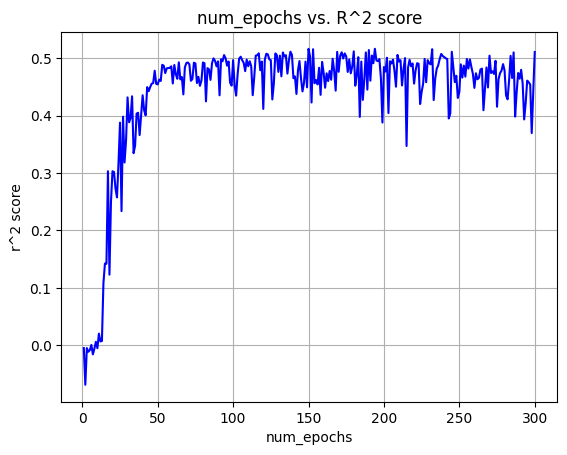

In [25]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [26]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5162998479151794
Corresponding RMSE: 0.21082494120658934
Corresponding num_epochs: 194
